## Neural Networks

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

In [2]:
plot_prefix <- 'plots/w12_'

### Create a sample Neural Network

Plot variable not specified, automatically selected `.vars = value`


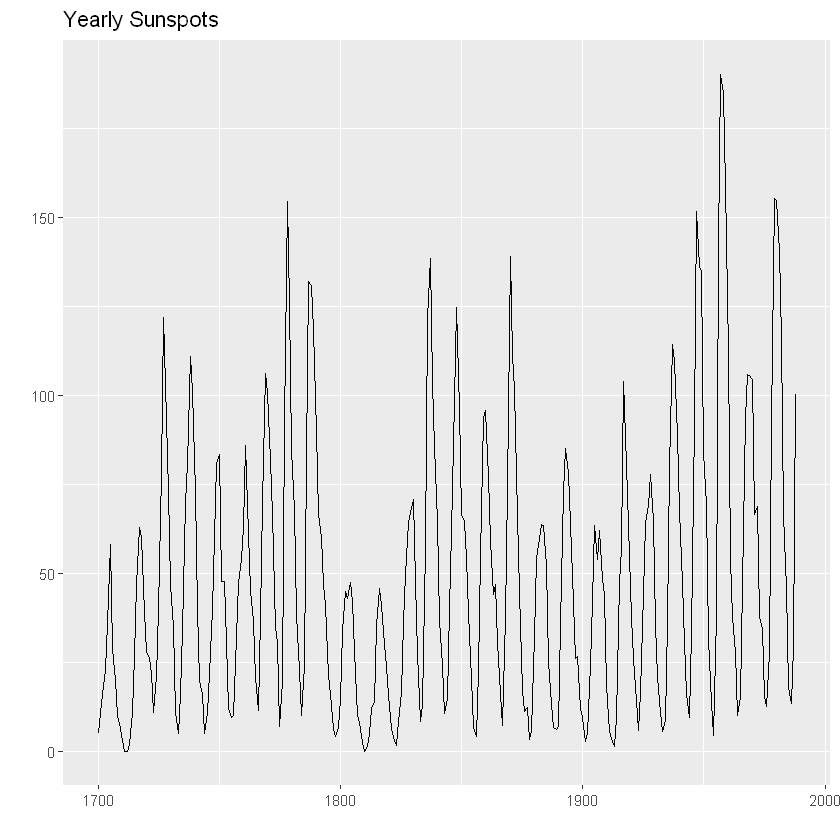

In [3]:
sunspots <- sunspot.year |> as_tsibble()
sunspots %>% autoplot() + labs(title='Yearly Sunspots', y='', x='')

ggsave(paste(plot_prefix, 'sunspots_ts.png', sep=''), height=4, width = 6)

In [4]:
nn_fit <- sunspots |>
  model(NNETAR(sqrt(value)))

In [5]:
nn_fit %>% report()

Series: value 
Model: NNAR(9,5) 
Transformation: sqrt(value) 

Average of 20 networks, each of which is
a 9-5-1 network with 56 weights
options were - linear output units 

sigma^2 estimated as 0.5043


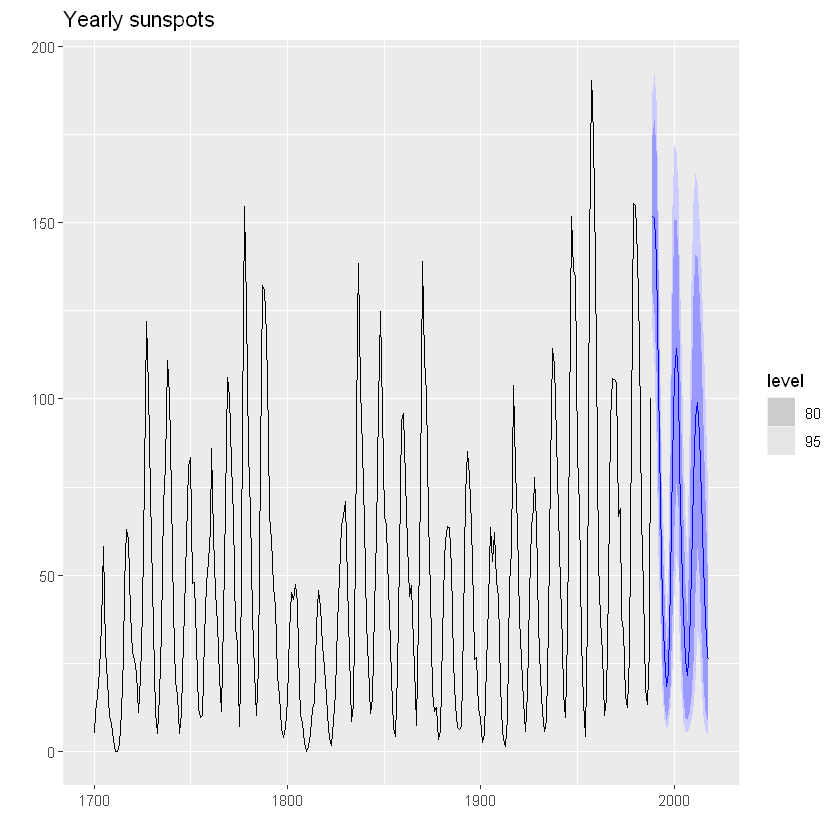

In [6]:
nn_fit |>
  forecast(h = 30) |>
  autoplot(sunspots) +
  labs(x = "", y = "", title = "Yearly sunspots")

ggsave(paste(plot_prefix, 'sunspots.png', sep=''), height=4, width = 6)

### Comparison with an ARIMA Model

In [7]:
fit_arima <- sunspots |>
  model(ARIMA(sqrt(value)))

fit_arima %>% report()

Series: value 
Model: ARIMA(2,0,1) w/ mean 
Transformation: sqrt(value) 

Coefficients:
         ar1      ar2      ma1  constant
      1.4709  -0.7523  -0.1221    1.7938
s.e.  0.0539   0.0491   0.0784    0.0606

sigma^2 estimated as 1.393:  log likelihood=-457.26
AIC=924.53   AICc=924.74   BIC=942.86


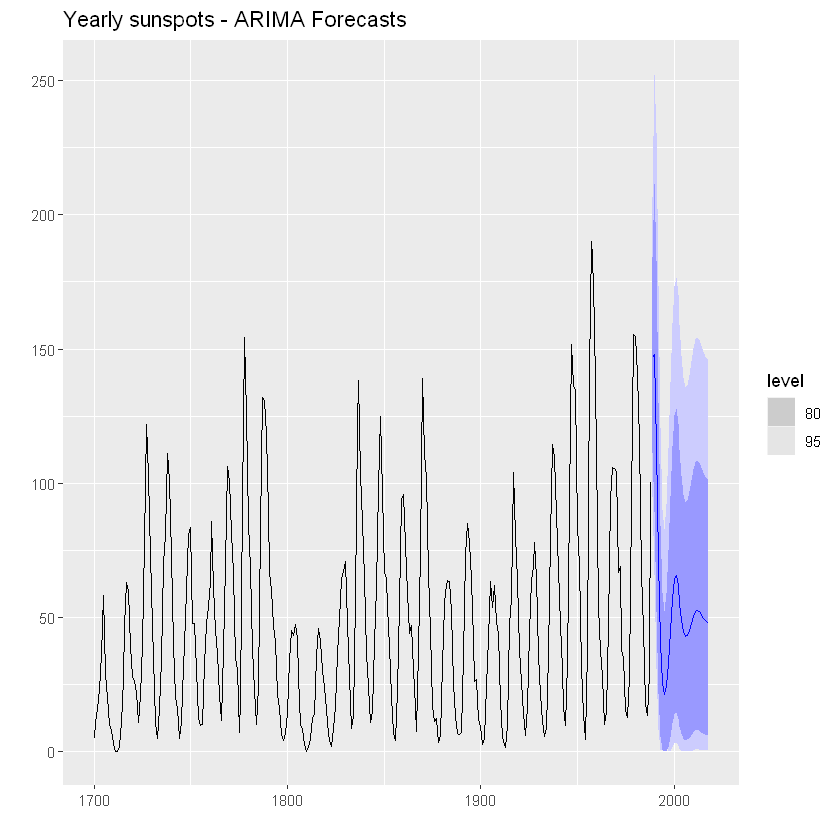

In [8]:
fit_arima |>
  forecast(h = 30) |>
  autoplot(sunspots) +
  labs(x = "", y = "", title = "Yearly sunspots - ARIMA Forecasts")

ggsave(paste(plot_prefix, 'sunspots_arima.png', sep=''), height=4, width = 6)

### Comparison with ETS Model

In [9]:
fit_ets <- sunspots |>
  model(ETS(sqrt(value)))

fit_ets %>% report()

Series: value 
Model: ETS(A,Ad,N) 
Transformation: sqrt(value) 
  Smoothing parameters:
    alpha = 0.9935462 
    beta  = 0.9522756 
    phi   = 0.8 

  Initial states:
    l[0]      b[0]
 2.48441 -5.952309

  sigma^2:  2.3184

     AIC     AICc      BIC 
1887.570 1887.868 1909.569 


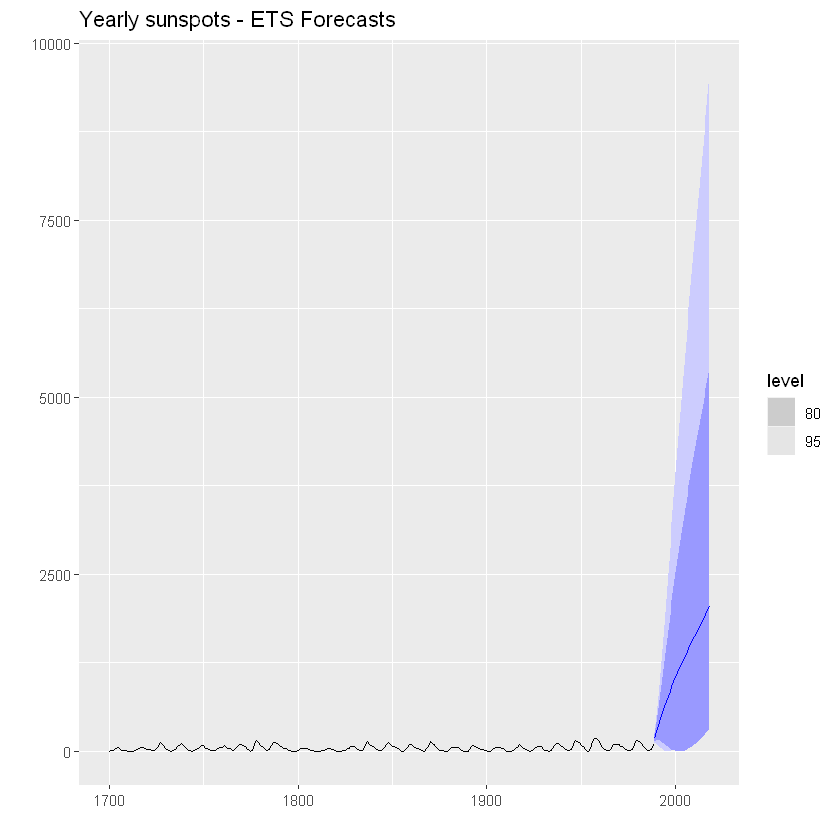

In [10]:
fit_ets |>
  forecast(h = 30) |>
  autoplot(sunspots) +
  labs(x = "", y = "", title = "Yearly sunspots - ETS Forecasts")

ggsave(paste(plot_prefix, 'sunspots_ets.png', sep=''), height=4, width = 6)

In [11]:
fit_ets_no_trend <- sunspots |>
  model(ETS(sqrt(value) ~ error('A') + trend('N') + season('N')))

fit_ets_no_trend %>% report()

Series: value 
Model: ETS(A,N,N) 
Transformation: sqrt(value) 
  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
     l[0]
 2.234688

  sigma^2:  2.9308

     AIC     AICc      BIC 
1952.346 1952.430 1963.346 


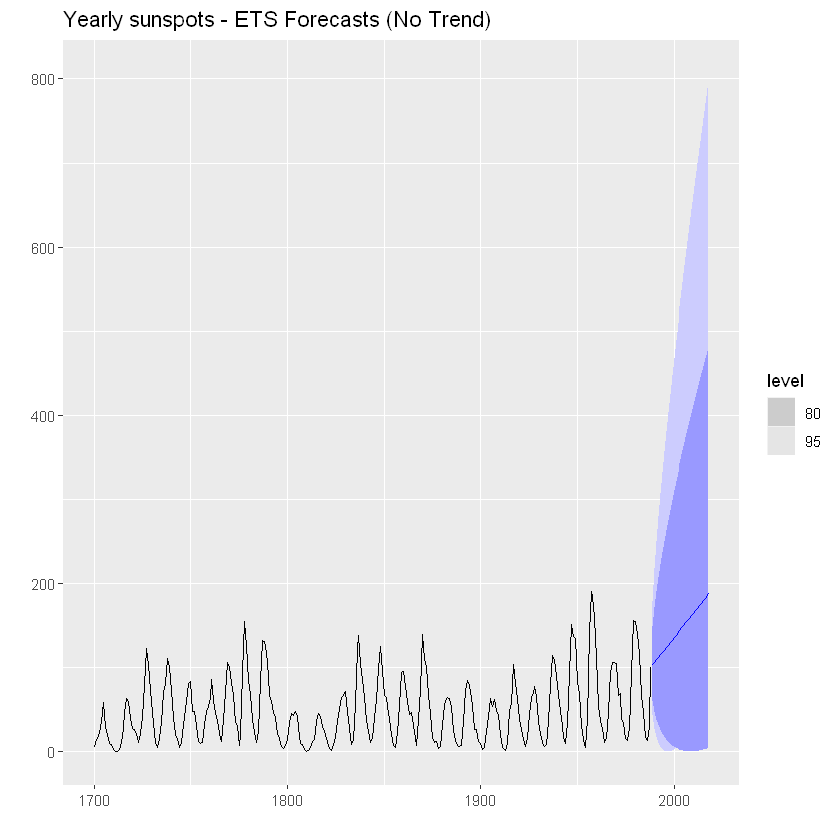

In [12]:
fit_ets_no_trend |>
  forecast(h = 30) |>
  autoplot(sunspots) +
  labs(x = "", y = "", title = "Yearly sunspots - ETS Forecasts (No Trend)")

ggsave(paste(plot_prefix, 'sunspots_ets_no_trend.png', sep=''), height=4, width = 6)

### Comparing a Data Series with More Seasonality

Plot variable not specified, automatically selected `.vars = Passengers`


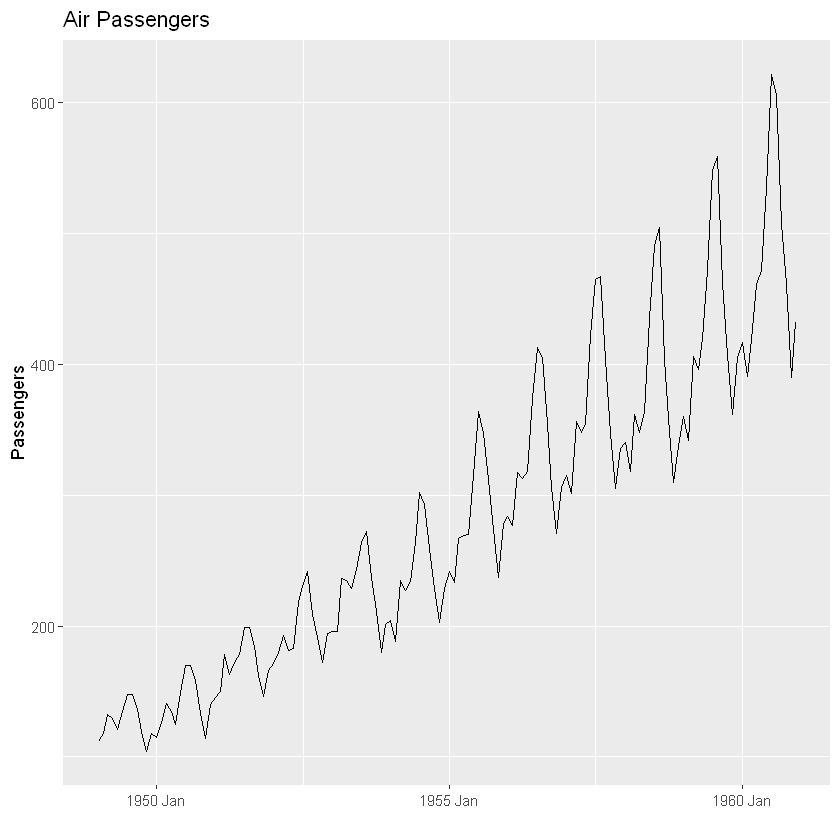

In [18]:
data(AirPassengers)
ap <- AirPassengers %>% as_tsibble()
names(ap) <- c('Month', 'Passengers')

ap_training <- ap %>% filter_index(. ~ "1958 Dec")
ap_test <- ap %>% filter_index("1959 Jan" ~ .)

ap %>% autoplot() + 
labs(title='Air Passengers', x='')

ggsave(paste(plot_prefix, 'ap.png', sep=''), height=3, width=5)

In [20]:

ap_fit <- ap_training |>
model(
    `ETS` = ETS(log(Passengers)),
    `ARIMA`= ARIMA(log(Passengers)),
    `NNETAR`= NNETAR(log(Passengers))
)

ap_fit %>% report()

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,sigma2,log_lik,AIC,AICc,BIC,MSE,AMSE,MAE,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<list>
ETS,0.0000479306,115.3407,-196.6814,-190.6814,-149.2941,0.001173214,0.001718692,0.005068919,NULL,NULL
ARIMA,0.0013821357,201.7674,-393.5349,-392.9466,-380.1242,NA,NA,NA,"1.132816+0i, -3.747184+0i","0.5250516+0.9094161i, -0.9094161+0.5250516i, -0.5250516-0.9094161i, 0.9094161-0.5250516i, 0.0000000+1.0501033i, -1.0501033-0.0000000i, 0.0000000-1.0501033i, 1.0501033+0.0000000i, -0.5250516+0.9094161i, -0.9094161-0.5250516i, 0.5250516-0.9094161i, 0.9094161+0.5250516i"
NNETAR,0.0030693062,NA,NA,NA,NA,NA,NA,NA,NULL,NULL


In [21]:
ap_fit_forecast <- ap_fit %>% forecast(h=24)

In [22]:
ap_fit_forecast %>% accuracy(ap_test) %>% select(.model, ACF1)

.model,ACF1
<chr>,<dbl>
ARIMA,0.1700304
ETS,0.2173228
NNETAR,0.5973769


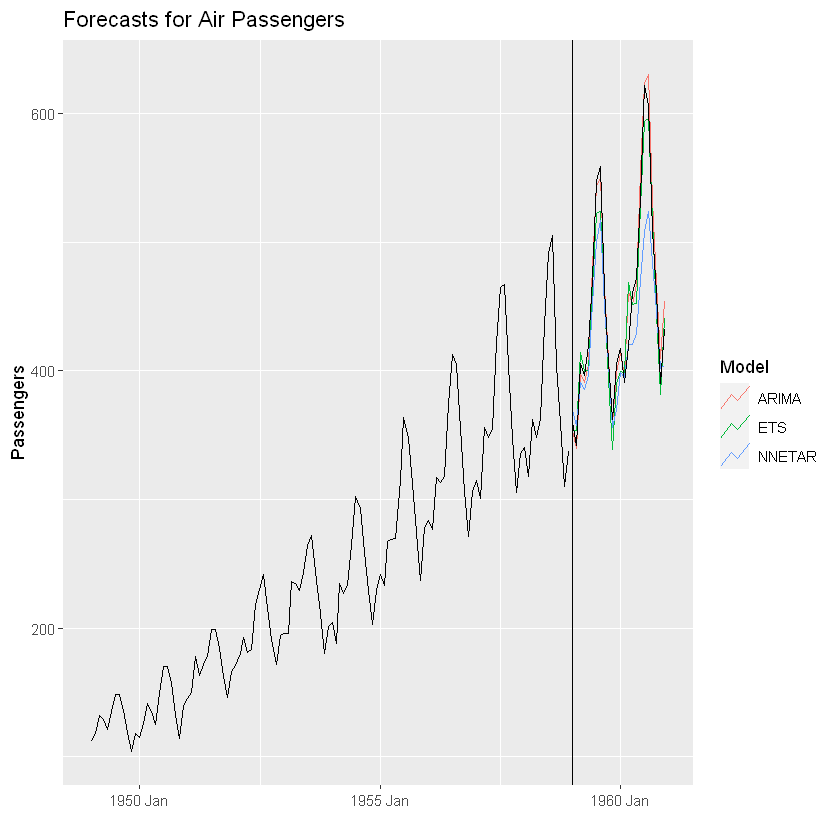

In [23]:
ap_fit_forecast %>% autoplot(ap_training, level=NULL) + autolayer(ap_test, Passengers) +
labs(title='Forecasts for Air Passengers', x='') +
geom_vline(xintercept = as.Date('1959-01-01')) +
guides(colour=guide_legend(title='Model'))

ggsave(paste(plot_prefix, 'ap_forecasts.png', sep=''), height=3, width=5)